<a href="https://colab.research.google.com/github/diyaannamathew/LIFESIGHT-Assessment/blob/main/Assesment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Loading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score



# Loading dataset
file_path = "/content/drive/MyDrive/LIFESIGHT/Assessment 2 - MMM Weekly.csv"
df = pd.read_csv(file_path)



In [ ]:
# Converting week to datetime
df['week'] = pd.to_datetime(df['week'], errors='coerce')

print("Data shape:", df.shape)
df.head()

Data shape: (104, 12)


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   week              104 non-null    datetime64[ns]
 1   facebook_spend    104 non-null    float64       
 2   google_spend      104 non-null    float64       
 3   tiktok_spend      104 non-null    float64       
 4   instagram_spend   104 non-null    float64       
 5   snapchat_spend    104 non-null    float64       
 6   social_followers  104 non-null    int64         
 7   average_price     104 non-null    float64       
 8   promotions        104 non-null    int64         
 9   emails_send       104 non-null    int64         
 10  sms_send          104 non-null    int64         
 11  revenue           104 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 9.9 KB
None


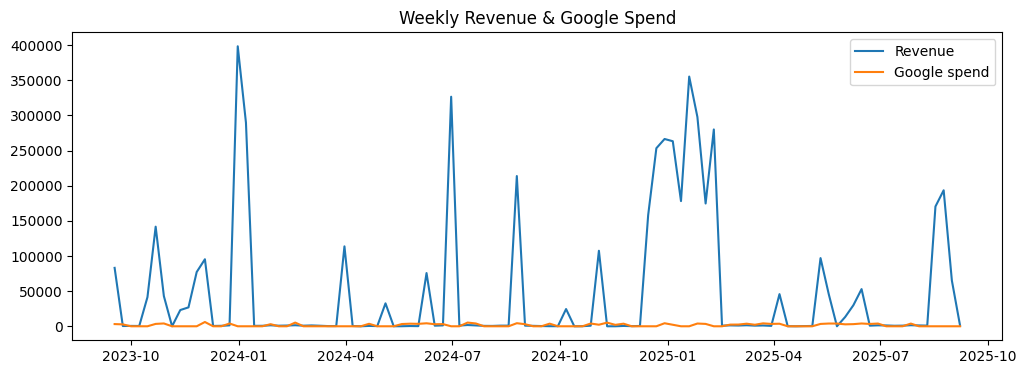

In [ ]:
#Visualization
plt.figure(figsize=(12,4))
plt.plot(df['week'], df['revenue'], label='Revenue')
plt.plot(df['week'], df['google_spend'], label='Google spend')
plt.legend()
plt.title("Weekly Revenue & Google Spend")
plt.show()



Feature Engineering & Preprocessing

In [ ]:
# Filling missing values with 0
df = df.fillna(0)

# Creating a simple trend feature
df['trend'] = df.index

# seasonality features using sine and cosine transformations
df['week_of_year'] = df['week'].dt.isocalendar().week.astype(int)
df['sin_season'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['cos_season'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

#adstock function to model carryover effects
def adstock(x, rate):
    """Applies an exponential decay (adstock) to a time series."""
    return np.array([np.sum(x[:i+1] * (1 - rate) ** (i - np.arange(i+1))) for i in range(len(x))])

# adstock to paid media features.
df['google_adstock'] = adstock(df['google_spend'], rate=0.5)
df['facebook_adstock'] = adstock(df['facebook_spend'], rate=0.5)
df['tiktok_adstock'] = adstock(df['tiktok_spend'], rate=0.5)
df['snapchat_adstock'] = adstock(df['snapchat_spend'], rate=0.5)

print("Engineered features added. The final dataframe looks like this:")
df.head()

Engineered features added. The final dataframe looks like this:


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue,trend,week_of_year,sin_season,cos_season,google_adstock,facebook_adstock,tiktok_adstock,snapchat_adstock
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16,0,37,-0.970942,-2.393157e-01,3130.14000,6030.800,2993.22000,2204.720
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02,1,38,-0.992709,-1.205367e-01,4269.07000,8256.840,1496.61000,1102.360
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01,2,39,-1.000000,-1.836970e-16,2134.53500,10021.420,748.30500,551.180
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78,3,40,-0.992709,1.205367e-01,1067.26750,12177.870,374.15250,275.590
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95,4,41,-0.970942,2.393157e-01,533.63375,11449.225,187.07625,137.795


In [ ]:
print(df.columns)

Index(['week', 'facebook_spend', 'google_spend', 'tiktok_spend',
       'instagram_spend', 'snapchat_spend', 'social_followers',
       'average_price', 'promotions', 'emails_send', 'sms_send', 'revenue',
       'trend', 'week_of_year', 'sin_season', 'cos_season', 'google_adstock',
       'facebook_adstock', 'tiktok_adstock', 'snapchat_adstock'],
      dtype='object')


 Single-Stage Model with Time-Series Cross-Validation

In [ ]:
X_cols = [
    "facebook_adstock", "tiktok_adstock", "snapchat_adstock", "google_adstock",
    "social_followers", "average_price", "promotions", "emails_send",
    "sms_send", "trend", "sin_season", "cos_season"
]
X = df[X_cols]
y = df["revenue"]

# Initializing variables for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-2, 2, 20)
r2_scores, rmse_scores = [], []

print("Running Single-Stage Model with Time-Series Cross-Validation...")

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Spliting data for the current fold
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Standardizing the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_test_scaled = scaler.transform(X_test_fold)

    # Fitting the Ridge model
    ridge = RidgeCV(alphas=alphas, cv=5)
    ridge.fit(X_train_scaled, y_train_fold)
    y_pred = ridge.predict(X_test_scaled)


    r2_scores.append(r2_score(y_test_fold, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_fold, y_pred)))

    print(f"Fold {i+1}: R2 = {r2_scores[-1]:.4f}, RMSE = {rmse_scores[-1]:.2f}")

print("\nAverage R2 across all folds:", np.mean(r2_scores))
print("Average RMSE across all folds:", np.mean(rmse_scores))

Running Single-Stage Model with Time-Series Cross-Validation...
Fold 1: R2 = -5.2634, RMSE = 68091.87
Fold 2: R2 = 0.1072, RMSE = 84201.23
Fold 3: R2 = -0.0532, RMSE = 105897.45
Fold 4: R2 = 0.2398, RMSE = 104071.61
Fold 5: R2 = -0.3014, RMSE = 66003.12

Average R2 across all folds: -1.0541868129320584
Average RMSE across all folds: 85653.05631364143


Final Model & Diagnostics

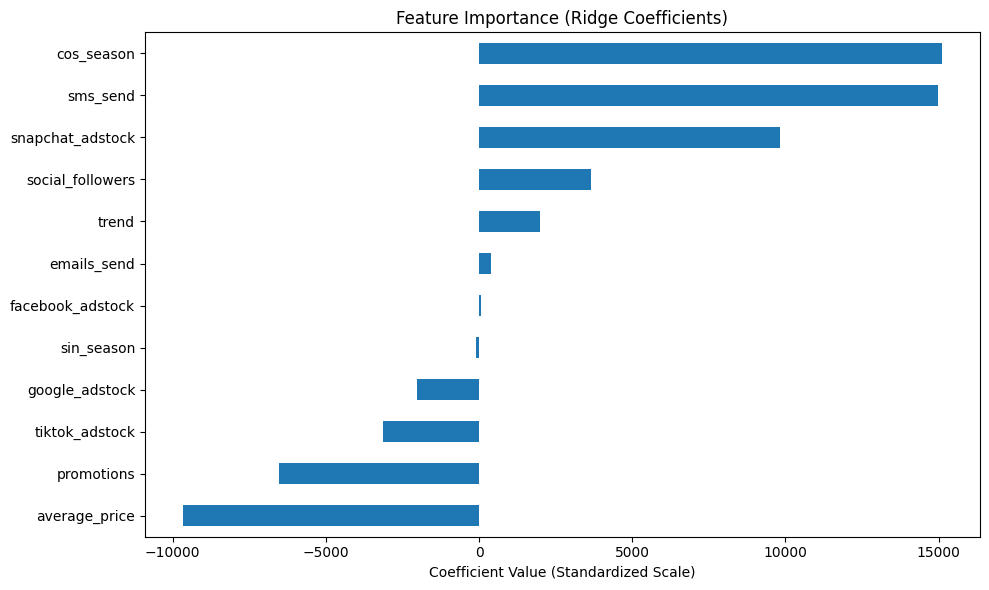

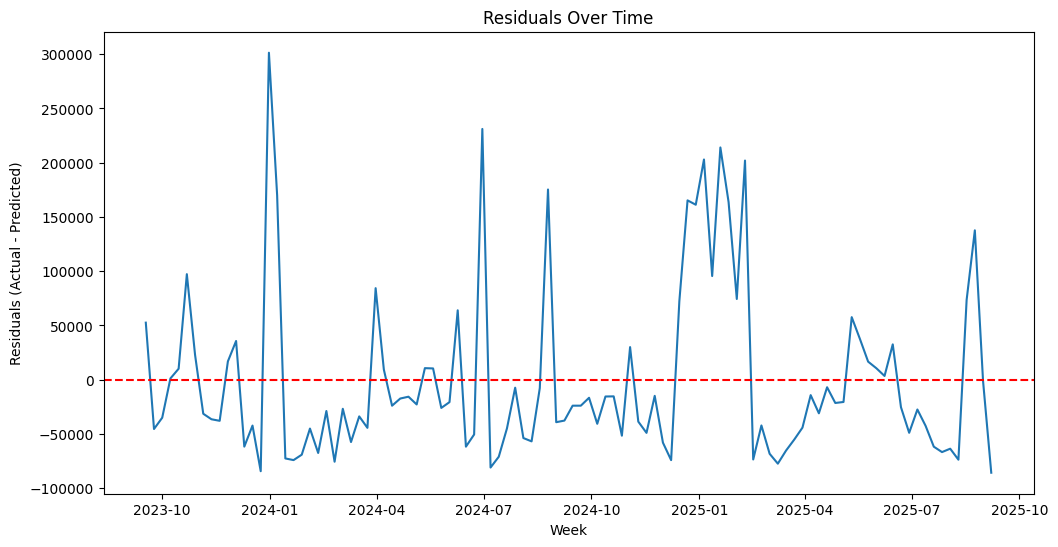

Final model's best alpha: 100.0
Final model's R2: 0.2693357133776786


In [ ]:
# Fitting the final single-stage model on the entire dataset for insights
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
final_model = RidgeCV(alphas=alphas, cv=5).fit(X_scaled, y)

# Feature Importance Plot
importance = pd.Series(final_model.coef_, index=X.columns).sort_values()
plt.figure(figsize=(10, 6))
importance.plot(kind="barh", title="Feature Importance (Ridge Coefficients)")
plt.xlabel("Coefficient Value (Standardized Scale)")
plt.tight_layout()
plt.show()

# Residual Analysis
residuals = y - final_model.predict(X_scaled)
plt.figure(figsize=(12, 6))
plt.plot(df['week'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Week")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

print("Final model's best alpha:", final_model.alpha_)
print("Final model's R2:", final_model.score(X_scaled, y))